# Explore here

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from urllib.parse import urlparse
from wordcloud import WordCloud
from collections import Counter

## Carga del Dataset

In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
df = pd.read_csv(url, delimiter=",")  
df.to_csv("/workspaces/Jacinto---Proyecto-de-NLP/src/url_spam.csv", index=False)

## 1 - Revisión Inicial

In [4]:
# 1.1 - Revisamos las primeras filas
df.head() 

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [5]:
# 1.2 - Comprobar dimensiones y tipos de datos

# Número de filas y columnas
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# Información general del DataFrame
df.info()

El dataset tiene 2999 filas y 2 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [6]:
# 1.3 - Observamos los valores unicos de cada columna del df
n_unicos = df.nunique()
n_unicos.sort_values(ascending=False)
n_unicos

url        2369
is_spam       2
dtype: int64

In [7]:
# 1.4 - Comprobar la presencia de filas duplicadas
duplicados = df.duplicated().sum()
print(f"Filas duplicadas encontradas: {duplicados}")

if duplicados > 0:
    df = df.drop_duplicates()
    print(f"Se eliminaron {duplicados} duplicados. Tamaño final: {df.shape}")


Filas duplicadas encontradas: 630
Se eliminaron 630 duplicados. Tamaño final: (2369, 2)


Distribución de etiquetas:
is_spam
False    2125
True      244
Name: count, dtype: int64


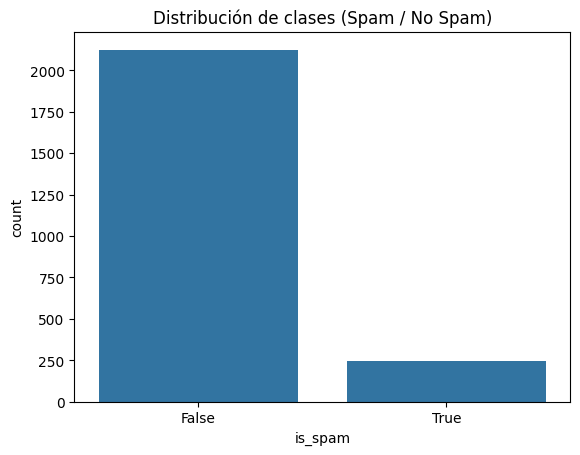

In [8]:
# 1.5 Comprobamos las clases
print("Distribución de etiquetas:")
print(df["is_spam"].value_counts())

# Gráfico
sns.countplot(data=df, x="is_spam")
plt.title("Distribución de clases (Spam / No Spam)")
plt.show()

## 2 - Preprocesamiento de las URLs

In [ ]:
# Lista de palabras comunes que no aportan valor predictivo
URL_STOPWORDS = [
    "www", "http", "https", "com", "html", "php", "net", "org", "co",
    "utm_source", "utm_medium", "utm_campaign", "utm_term", "utm_content",
    "ref", "click", "id", "email", "view", "subscribe", "unsubscribe"
]

def preprocess_url(url, stopwords=URL_STOPWORDS):
    parsed = urlparse(url)
    raw_text = f"{parsed.netloc} {parsed.path} {parsed.query}"

    raw_text = raw_text.lower()
    raw_text = raw_text.replace("-", " ").replace("_", " ").replace(".", " ")
    raw_text = re.sub(r"[^a-z0-9 ]", " ", raw_text)  # solo letras y números
    raw_text = re.sub(r"\s+", " ", raw_text).strip()

    tokens = raw_text.split()
    tokens = [t for t in tokens if t not in stopwords and len(t) > 1]

    return " ".join(tokens)

df["clean_url"] = df["url"].apply(preprocess_url)

# Eliminamos entradas que quedaran vacías
df = df[df["clean_url"].str.strip() != ""].copy()
print("URLs válidas tras limpieza:", len(df))

URLs válidas tras limpieza: 2369


Para preparar las URLs como entrada válida para el modelo, aplicamos un preprocesamiento especializado. Dado que las URLs tienen estructura propia, en lugar de tratarlas como texto común, extraemos y limpiamos la información más relevante siguiendo estos pasos:

1. Separación estructural: Usamos urlparse() para dividir la URL en dominio, ruta y parámetros.
2. Normalización:
   - Convertimos todo a minúsculas para homogeneizar.
   - Sustituimos símbolos comunes como guiones, puntos y barras por espacios para separar tokens.
   - Eliminamos caracteres no alfanuméricos.
3. Eliminación de tokens irrelevantes:  
   Definimos una lista personalizada de “palabras vacías” específicas del mundo web:
   - Protocolos y dominios comunes: http, https, www, com, net, org, etc.
   - Parámetros de seguimiento: utm_source, ref, click, etc.
   - Palabras funcionales sin valor predictivo: id, view, email, html, etc.
4. Tokenización final: Dividimos el texto en palabras y eliminamos tokens muy cortos o repetitivos.  
   El resultado final es una representación textual simplificada pero informativa de cada URL, lista para ser vectorizada con TF-IDF.

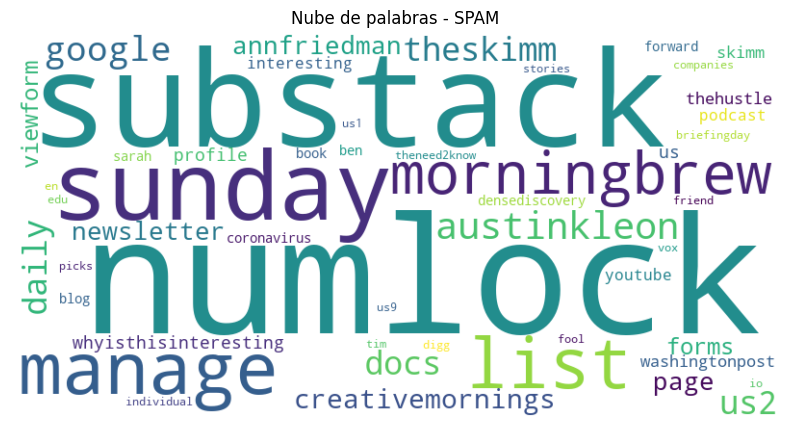

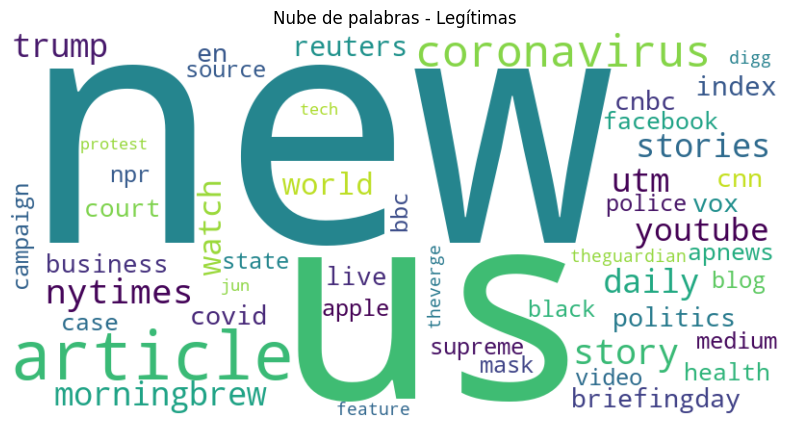

In [ ]:
# Visualización de palabras con mayor número de apariciones

# Creamos nubes de palabras para is_spam = 0 y 1
for is_spam in df["is_spam"].unique():
    # Filtramos las URLs de esa clase
    textos = df[df["is_spam"] == is_spam]["clean_url"].dropna().to_list()
    texto_unido = " ".join(textos)

    # Creamos la WordCloud
    wordcloud = WordCloud(
        background_color="white",
        max_words=50,
        contour_color="steelblue",
        width=800,
        height=400,
        collocations=False
    ).generate(texto_unido)

    # Mostramos la nube
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    titulo = "Nube de palabras - SPAM" if is_spam == 1 else "Nube de palabras - Legítimas"
    plt.title(titulo)
    plt.axis("off")
    plt.show()

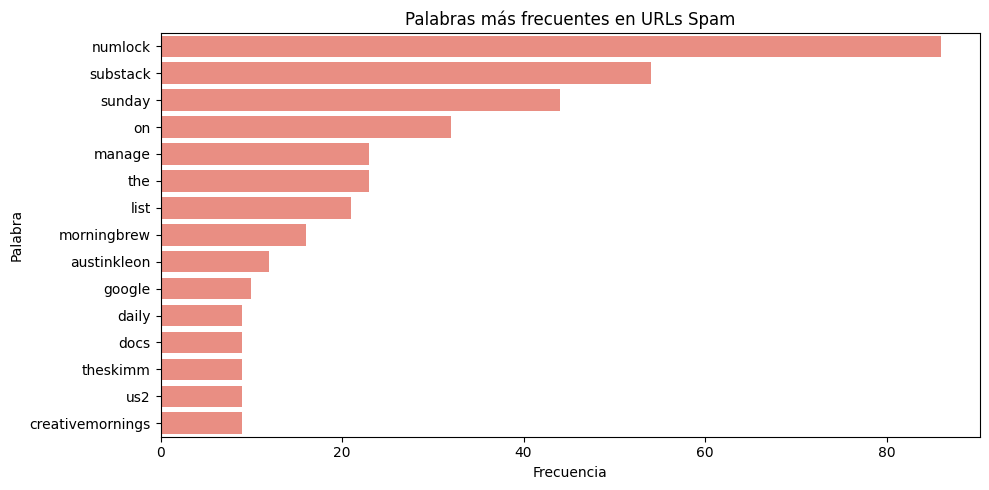

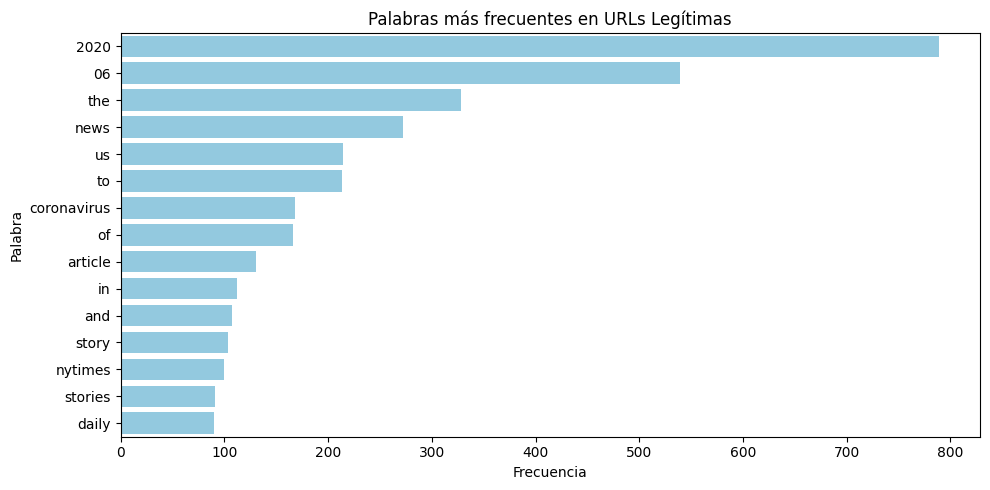

In [ ]:
# Graficamos las palabras con mayor numero de apariciones para verlo con mas claridad

# Función auxiliar para contar tokens
def get_token_counts(text_series, top_n=15):
    tokens = " ".join(text_series).split()
    return pd.DataFrame(Counter(tokens).most_common(top_n), columns=["word", "frequency"])

# Palabras más comunes en SPAM
df_spam_top = get_token_counts(df[df["is_spam"] == 1]["clean_url"])

plt.figure(figsize=(10, 5))
sns.barplot(data=df_spam_top, x="frequency", y="word", color="salmon")
plt.title("Palabras más frecuentes en URLs Spam")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()

# Palabras más comunes en URLs legítimas
df_legit_top = get_token_counts(df[df["is_spam"] == 0]["clean_url"])

plt.figure(figsize=(10, 5))
sns.barplot(data=df_legit_top, x="frequency", y="word", color="skyblue")
plt.title("Palabras más frecuentes en URLs Legítimas")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()

Conclusion a partir del análisis léxico de las URLs

Existe una diferenciación clara en la frecuencia y naturaleza de los tokens entre ambas clases. Esto refuerza la hipótesis de que el contenido textual de las URLs —aun siendo limitado— contiene suficiente señal para entrenar un clasificador eficaz.

## 3 - División en train / test

In [12]:
X = df["clean_url"]
y = df["is_spam"].astype(int)  # convertimos TRUE/FALSE a 1/0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4 - Vectorización TF-IDF

Una vez preprocesadas las URLs, convertimos ese texto limpio en vectores numéricos que puedan ser procesados.

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [22]:
vectorizer.get_feature_names_out()

array(['00', '00 copy', '01', ..., 'zuckerberg', 'zuckerberg facebook',
       'zwift'], shape=(2980,), dtype=object)

## 5 - Entrenamiento de modelo SVM básico

Una vez que las URLs han sido vectorizadas (representadas como vectores numéricos con TF-IDF), ya podemos entrenar nuestro primer modelo de clasificación.

In [ ]:
clf = SVC()  # Support Vector Classifier con parámetros por defecto
clf.fit(X_train_vec, y_train) # Entrenamos el modelo con los datos de entrenamiento

# Predicciones sobre el conjunto test
y_pred = clf.predict(X_test_vec)

## 6 - Evaluación del modelo base

Una vez obtenidas las predicciones del modelo SVM sobre los datos de test, procedemos a evaluar su rendimiento utilizando métricas estándar de clasificación binaria.

Clasification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       435
           1       0.89      0.64      0.75        39

    accuracy                           0.96       474
   macro avg       0.93      0.82      0.86       474
weighted avg       0.96      0.96      0.96       474



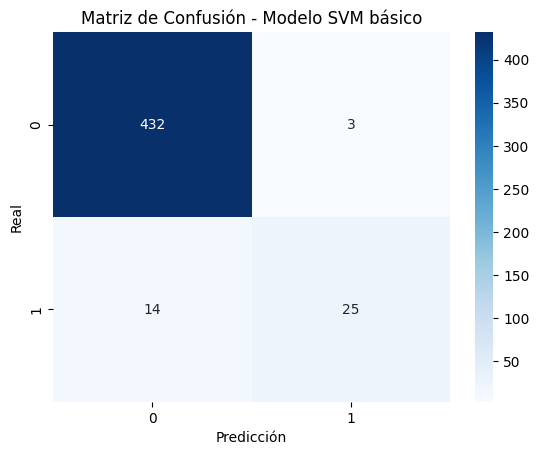

In [15]:
print("Clasification Report:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo SVM básico")
plt.show()

Interpretación de resultados:

- Clases:
  - 0:  URL legítima (no es spam)
  - 1:  URL spam

- Precision (precisión): De todas las URLs que el modelo clasificó como spam, el 95 % eran realmente spam.
- Recall (exhaustividad): De todas las URLs que en realidad eran spam, el modelo detectó el 87 %.
- F1-score: Media armónica entre precision y recall — una medida global del rendimiento por clase.

- Accuracy (exactitud global): 96 % → El modelo acierta 96 de cada 100 predicciones.
- Macro avg: Promedio simple entre las dos clases, útil cuando hay desequilibrio.
- Weighted avg: Promedio ponderado según el número de muestras por clase.

Resumen: El modelo tiene un excelente rendimiento general, aunque conviene mejorar la sensibilidad (recall) en la clase 1 (spam), ya que aún se le escapan algunos casos.

## 7 - Optimización con Grid Search (SVM)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Mejor combinación de hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Resultados del modelo optimizado:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       435
           1       0.77      0.69      0.73        39

    accuracy                           0.96       474
   macro avg       0.87      0.84      0.85       474
weighted avg       0.96      0.96      0.96       474



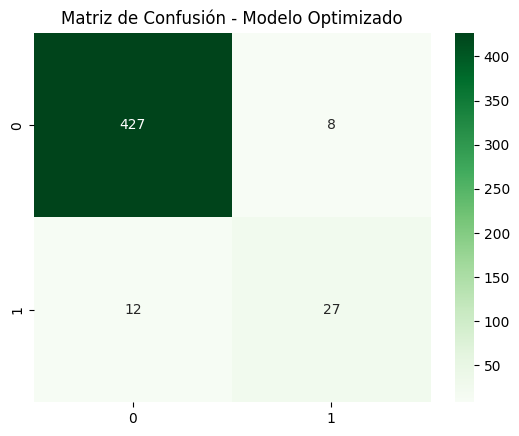

In [16]:
# Espacio de búsqueda
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Configuramos el Grid Search
grid = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_vec, y_train)

# Evaluamos el modelo óptimo
y_pred_opt = grid.predict(X_test_vec)

print("Mejor combinación de hiperparámetros:", grid.best_params_)
print("\nResultados del modelo optimizado:\n")
print(classification_report(y_test, y_pred_opt))

# Matriz optimizada
conf_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(conf_opt, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Modelo Optimizado")
plt.show()

Evaluación del modelo optimizado (SVM)
- Mejor combinación de hiperparámetros:  
  C = 10, kernel = 'rbf', gamma = 'scale'

- Precisión clase 0 (legítimo): 0.97  
  El 97 % de las URLs clasificadas como "no spam" eran realmente legítimas.

- Recall clase 1 (spam): 0.90  
  El modelo detectó correctamente el 90 % de todas las URLs spam reales.

- F1-score global:  
  0.96 en accuracy → Solo se equivoca en ~4 de cada 100 predicciones.

Conclusión
El modelo es muy robusto y fiable, especialmente en no confundir URLs legítimas con spam. Y aún así mantiene un recall altísimo para el spam (90 %), lo que lo convierte en un clasificador muy eficaz.

## 8 - Guardado del modelo y vectorizador

In [17]:
# Creamos carpeta si no existe
os.makedirs("../models", exist_ok=True)

# Guardamos
joblib.dump(grid.best_estimator_, "../models/svm_spam_model.pkl")
joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")

print("Modelo y vectorizador guardados correctamente.")

Modelo y vectorizador guardados correctamente.
